In [131]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from highlight_text import fig_text, ax_text

df = pd.read_csv('WHR2024.csv')

# rename column
len_to_remove = len('Explained by: ')
for col in df.columns:
    if 'Explained by: ' in col:
        new_name = col[len_to_remove:]
        df[new_name] = df[col]
        df.drop(col, axis=1, inplace=True)

# create part of each explainer
not_explainers = ['Country name', 'Ladder score',
                  'upperwhisker', 'lowerwhisker', 'total']
explainers = ['Dystopia + residual', 'Log GDP per capita', 'Social support',
              'Healthy life expectancy', 'Freedom to make life choices',
              'Generosity', 'Perceptions of corruption']
for explainer in explainers:
    df['share_'+explainer] = df[explainer]/df['Ladder score']*100

# open and merge with geo data
world = gpd.read_file(
    "ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")
europe = world[world['CONTINENT'] == 'Europe']
data = europe.merge(
    df, how='left',
    left_on='NAME',
    right_on='Country name'
)
europe.columns
data = data[['geometry']+df.columns.to_list()]
data = data[data['Country name'] != 'Russia']
data.dropna(inplace=True)
print(data.columns)
data.sample(3)

Index(['geometry', 'Country name', 'Ladder score', 'upperwhisker',
       'lowerwhisker', 'Dystopia + residual', 'Log GDP per capita',
       'Social support', 'Healthy life expectancy',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'share_Dystopia + residual',
       'share_Log GDP per capita', 'share_Social support',
       'share_Healthy life expectancy', 'share_Freedom to make life choices',
       'share_Generosity', 'share_Perceptions of corruption'],
      dtype='object')


,geometry,Country name,Ladder score,upperwhisker,lowerwhisker,Dystopia + residual,Log GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,share_Dystopia + residual,share_Log GDP per capita,share_Social support,share_Healthy life expectancy,share_Freedom to make life choices,share_Generosity,share_Perceptions of corruption
30,"POLYGON ((13.80648 46.50931, 14.63247 46.43182...",Slovenia,6.743,6.843,6.643,1.683,1.786,1.502,0.695,0.789,0.157,0.131,24.959217,26.486727,22.274952,10.306985,11.701023,2.328341,1.942755
11,"POLYGON ((26.49433 55.61511, 26.58828 55.16718...",Lithuania,6.818,6.896,6.739,2.307,1.766,1.454,0.598,0.533,0.044,0.116,33.836902,25.902024,21.325902,8.770901,7.817542,0.645351,1.701379
13,"POLYGON ((27.98113 59.47537, 27.98112 59.47537...",Estonia,6.448,6.524,6.371,1.138,1.752,1.527,0.657,0.805,0.166,0.401,17.648883,27.171216,23.681762,10.189206,12.484491,2.574442,6.218983


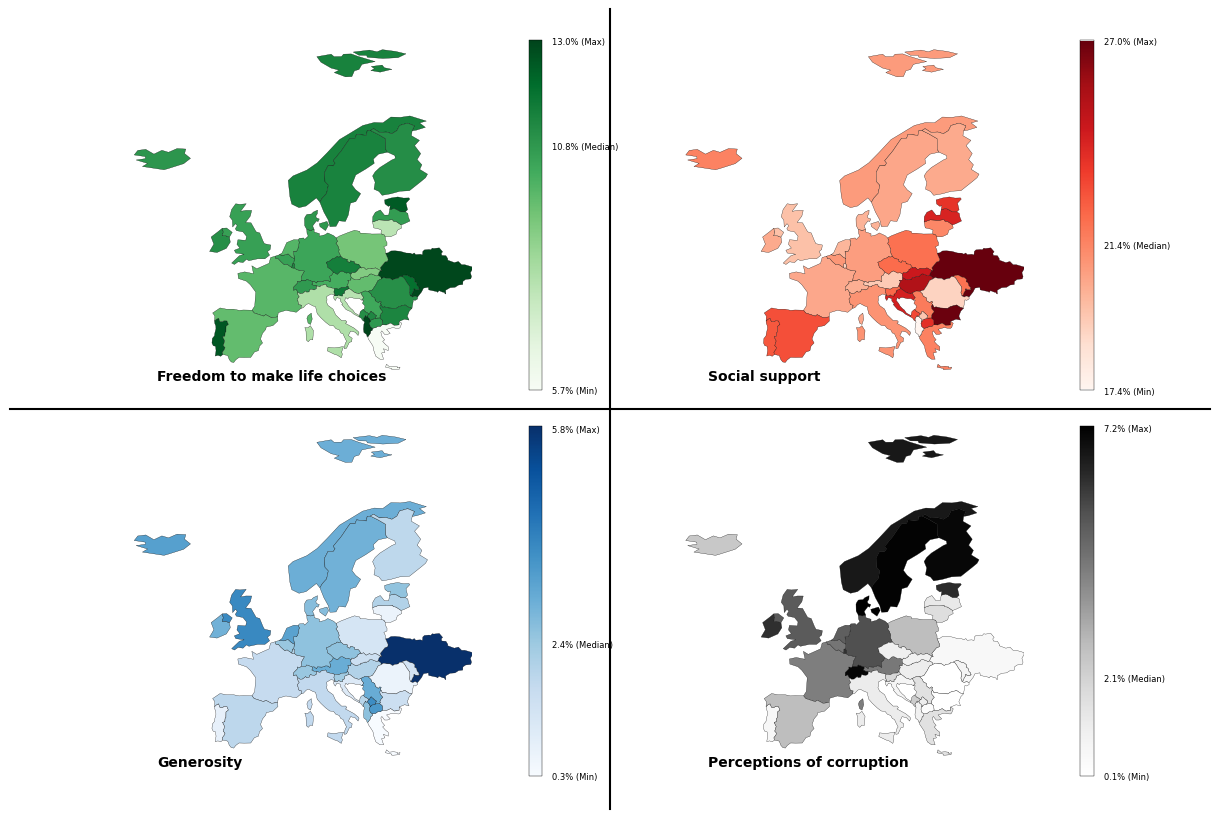

In [135]:
# initialize the figure
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axs = axs.flatten()

def plot_map_on_ax(column, ax, cmap):

    # define colors
    min_rate, max_rate = data[column].min(), data[column].max()
    norm = mcolors.Normalize(vmin=min_rate, vmax=max_rate)

    # create the plot
    data.plot(
        column=column,
        cmap=cmap, norm=norm,
        edgecolor='black', linewidth=0.2,
        ax=ax
    )

    # custom axis
    ax.set_xlim(-25, 40)
    ax.set_ylim(32, 82)
    ax.axis('off')

    return cmap, norm

columns = [
    'share_Freedom to make life choices',
    'share_Social support',
    'share_Generosity',
    'share_Perceptions of corruption'
]
cmaps = [cm.Greens, cm.Reds, cm.Blues, cm.Greys]
for ax, column, cmap in zip(axs, columns, cmaps):

    cmap, norm = plot_map_on_ax(column=column, ax=ax, cmap=cmap)

    # create and custom colorbars
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0)
    cbar = plt.colorbar(sm, cax=cax, orientation='vertical')
    values_for_colorbar = [
        round(data[column].min(), 1),
        round(data[column].median(), 1),
        round(data[column].max(), 1)
        ]
    # ['Min', 'Median', 'Max']
    labels_for_colorbar = [
        str(val)+f'% ({label})' for val, label in zip(values_for_colorbar,['','',''])]
    cbar.set_ticks(values_for_colorbar)
    cbar.set_ticklabels(labels_for_colorbar)
    cbar.ax.tick_params(labelsize=6, width=0)
    cbar.outline.set_linewidth(0.3)

    ax_text(
        -20, 34,
        column[6:],
        ha='left', va='center',
        fontsize=10, fontweight='bold',
        color='black',
        ax=ax
    )

# add grid between axes
fig.lines.extend([Line2D([0, 1], [0.5, 0.5], color="black", transform=fig.transFigure, linewidth=1.5)])
fig.lines.extend([Line2D([0.5, 0.5], [0, 1], color="black", transform=fig.transFigure, linewidth=1.5)])

# display the plot
fig.tight_layout(pad=2)
fig.savefig('mutliple_maps.png', dpi=300, bbox_inches='tight')
plt.show()